## Synthetic-aperture radar 

**!! Satellite data not included !!**

### A real-life example of Applied Linear Algebra

We have learned in the course how to use methods from Linear Algebra to obtain more information about a given linear system. 

In this last example we will see that the methods we have seen this term are used in actual real-life scientific applications. For this we will take a look at how to examine the vegetation cover of a region with the help of satellite data. 

This notebook is split into three parts: 
* Basic knowledge on satellite imagery and the data we get from it. 
* What is the Normalized Difference Vegetation Index (NDVI)
* Caclulation of the NVDI for the given satellite data  

The information in this notebook is based on the information freely available on Wikipedia. The Python code is from 

https://github.com/parulnith/Satellite-Imagery-Analysis-with-Python

which is an introduction to "Satellite Imagery Analysis with Python" from Parul Pandey. 

### Basics on satellite imagery 

Synthetic-aperture radar (SAR) is a form of radar that is used intensively to create two-dimensional images or even three-dimensional reconstructions of the surface of the earth.

SAR is typically mounted on a moving platform, such as an aircraft or spacecraft. The distance the SAR device travels over a target in the time taken for the radar pulses to return to the antenna creates the large synthetic antenna aperture (the size of the antenna). The idea behind that is, that usually the larger the aperture, the higher the image resolution. Hence a SAR on a satellite can create high-resolution images with comparatively small physical antennas.

**How does it work**
Electromagnetic waves are transmitted sequentially to "illuminate" a target scene. The echo of each pulse is received and the system electronics digitizes and stores the data for subsequent processing. As the SAR device on board the aircraft or spacecraft moves, the antenna location relative to the target changes with time. Signal processing of the successive recorded radar echoes allows to combine the recordings from these multiple antenna positions. This builds a virtual aperture that is much longer than the physical antenna width. That is the source of the term "synthetic aperture".

![title](img/Synthetic_Aperture_Radar.png)

There are multiple ways to obtain satellite data. For example NASA and ESA both have website where one can get raw earth observation data for free:
 - https://earthdata.nasa.gov/
 - https://scihub.copernicus.eu/
 
We will use here data from LandViewer, a simple, user-friendly web interface published by Earth Observing System (EOS) of NASA.
(check out https://eos.com/lv/ for more information)
 
In particular we will consider Surface Reflectance (SR) Data. Simply put, the SR data is recorded satellite data which has been algorithmically corrected to remove any interference from the atmosphere. Moreover the Python code is written for so-called 4 band image. These are images with spectral data for Blue, Green, Red and Near-infrared values. If you want to work with more or different spectral bands you have to change the code accordingly. 

Satellite data is stored in .TIF files. In the lecture I used the satellite data recorded by the satellite Sentinal 2 on the 28th of August 2020 and a few month earlier on the 20 Feburary 2020 while passing over the coast of British Columbia. 

Note that do to the size of the satellite images they are not included here. Please download your own and work locally, not on ubc.syzygy.ca.


### Analysing the data

In [1]:
import math
import numpy
import rasterio
import matplotlib.pyplot as plt

#### Importing the image

In [2]:
image_file_1 = #path-to-your-satellite-data
sat_data_1 = rasterio.open(image_file_1)

#### Calculating the dimensions of the image on earth in metres
Let us get some information about our satellite data

In [5]:
width_in_projected_units = sat_data_1.bounds.right - sat_data_1.bounds.left
height_in_projected_units = sat_data_1.bounds.top - sat_data_1.bounds.bottom

print("Width: {} m, Height: {} m".format(width_in_projected_units, height_in_projected_units))

Width: 34020.0 m, Height: 36390.0 m


#### Rows and Columns

In [6]:
print("Rows: {}, Columns: {}".format(sat_data_1.height, sat_data_1.width))

Rows: 3639, Columns: 3402


#### Converting the pixel co-ordinates to longitudes and latitudes

In [8]:
# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = sat_data_1.height - 1
col_max = sat_data_1.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = sat_data_1.transform * (row_min, col_min)
botright = sat_data_1.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (465380.0, 5488630.0)
Bottom right corner coordinates: (501760.0, 5454620.0)


#### Bands

The image that we are inspecting is a multispectral image consisting of 4 bands int he order B,G,R,N where N stands for near infrared.each band is stored as a numpy array.

In [10]:
print(sat_data_1.count)

# sequence of band indexes
print(sat_data_1.indexes)

4
(1, 2, 3, 4)


### Visualising the Satellite Imagery

We can use matplotlib to visualise the senor image data sets from the satellite since it essentially consists of arrays.

In [11]:
# Load the 4 bands into 2d arrays - recall that we previously learned PlanetScope band order is BGRN.
b, g, r, n = sat_data_1.read()

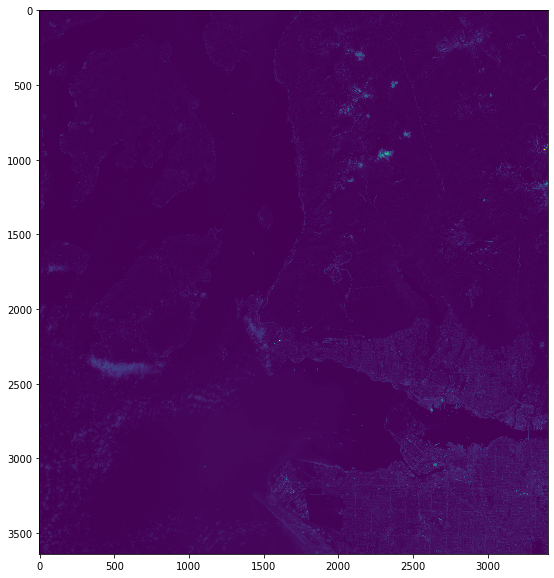

In [12]:
# Displaying the blue band.
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(b, interpolation='nearest')
plt.show()

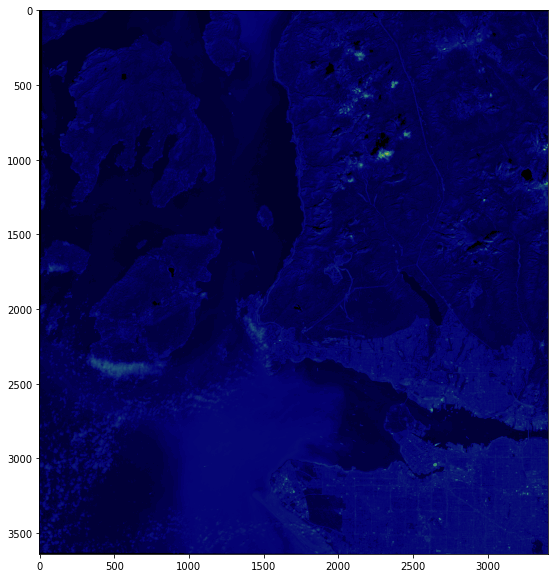

In [13]:
# Displaying the green band.

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(g, interpolation='nearest')
fig = plt.imshow(g)
fig.set_cmap('gist_earth')
plt.show()

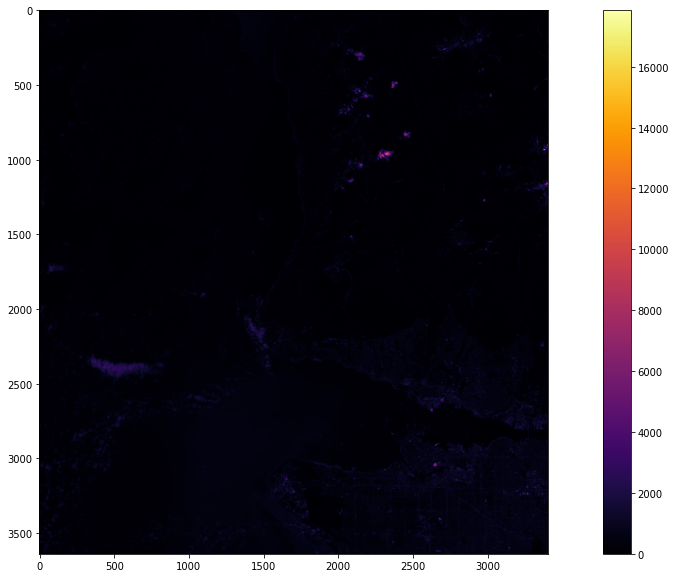

In [14]:
# Displaying the red band.

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(r, interpolation='nearest')
fig = plt.imshow(r)
fig.set_cmap('inferno')
plt.colorbar()
plt.show()

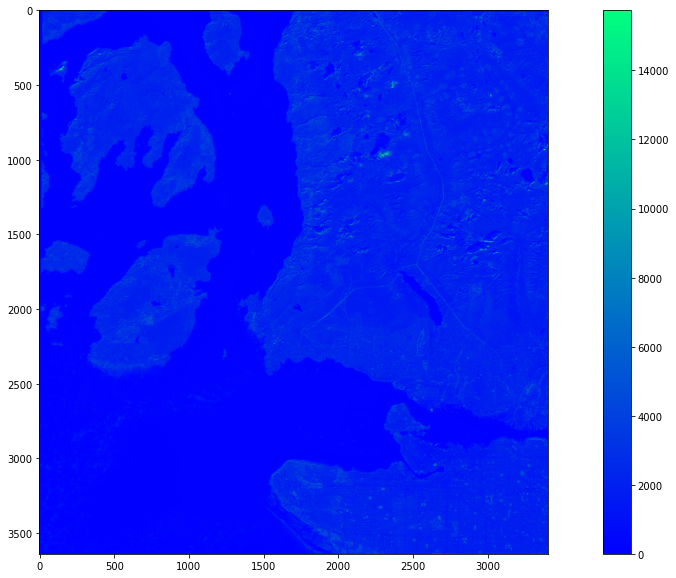

In [15]:
# Displaying the infrared band.

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(n, interpolation='nearest')
fig = plt.imshow(n)
fig.set_cmap('winter')
plt.colorbar()
plt.show()

### Working with Satellite Data 
Different kinds of data are captured by satellite sensors. One specific type of data specifically measures wavelengths of light absorbed and reflected by green plants. With this data we can calculate a **vegetation index**, i.e. an indicator of the greenness of the observed area. It is used to measure and monitor the health of a vegetation. 

#### Some Biology
Chlorophyll, the pigments in plant leaves, strongly absorbs visible light (from 400 to 700 nanometers) for use in photosynthesis. This is the so-called photosynthetically active radiation (PAR) spectral region or simply the visible spectrum of light.

![title](img/EM-spectrum.png)

On the other hand, the cell structure of the leaves strongly reflects near-infrared light (from 700 to 1100 nanometers). 
The reason for that is, that photon energy at wavelengths longer than about 700 nanometers is too small to synthesize organic molecules, i.e. the plant can not generate energy from photons with these wavelength. A strong absorption at these wavelengths would therefore only result in overheating the plant and possibly damaging the tissues. 

As a result, live green plants appear relatively dark in the PAR and relatively bright in the near-infrared. By contrast, clouds and snow tend to be rather bright in the red (as well as other visible wavelengths) and quite dark in the near-infrared.
It is therefore natural to exploit the strong differences in plant reflectance to determine their spatial distribution in satellite images.

#### Back to the vegetation index
One of the most widely used index to measure vegetation is the **Normalized Difference Vegetation Index (NDVI)**. It was developed by NASA scientist Compton Tucker in 1977. 
The NDVI compares the amount of reflected near-infrared light to reflected visible red light and is directly related to the photosynthetic capacity and hence the amount of energy absorption of the plants canopies.

$$
  \rm{NDVI}= \frac{({\rm{NIR}}-{\rm{Red}})}{({\rm{NIR}}+{\rm{Red}})}
$$

where $\rm{Red}$ and $\rm{NIR}$ stand for the spectral reflectance measurements acquired in the red (visible) and near-infrared regions, respectively. These spectral reflectances take on values between 0.0 and 1.0. The NDVI thus varies between -1.0 and +1.0.

<img src=img/NDVI.png width ="1000" height=1000 >

Note that even in densely populated urban areas the value of a normal NDVI is still positive but close to zero. Negative values are more likely to be disturbed in the atmosphere and some specific materials. Note also that water and ice have negative values.


### Calculating Normalized Difference Vegetation Index for our satellite data

#### Extracting the data from the red and near-infrared bands


In [31]:
band_red_1 = sat_data_1.read(3)
band_nir_1 = sat_data_1.read(4)

#### Calculating NDVI

In [32]:
# Do not display error when divided by zero 
numpy.seterr(divide='ignore', invalid='ignore')

# NDVI 
ndvi_1 = (band_nir_1.astype(float) - band_red_1.astype(float)) / (band_nir_1 + band_red_1)

#### Checking the range of NDVI values(excluding NaN)
Let's print the minimum and maximum values in our calculated ndvi. Because we're using the NDVI formula to normalize the input bands, we know that our expected values should fall within -1.0 to +1.0.

In [33]:
print("Minimum NDVI for image_file_1 ",numpy.nanmin(ndvi_1)) 
print("Maximum NDVI for image_file_1: ",numpy.nanmax(ndvi_1))

Minimum NDVI for image_file_1  -0.9960079840319361
Maximum NDVI for image_file_1:  0.9998716714789863


#### Saving the NDVI images

For each of the two observation dates we will save the results to a new single band image. This new image file will use the geospatial data from the original satellite data tif images.

In [20]:
# get the metadata of original images:
meta_1 = sat_data_1.meta

# meta data of the image
print("Meta data of the first image: \n", meta_1)

# get the dtype of our NDVI array:
ndvi_1_dtype = ndvi_1.dtype

# dtype of our NDVI array of the image
print("\n dtype of NDVI arrayn of first image: ", ndvi_1_dtype)

# set the source metadata as kwargs we'll use to write the new data:
kwargs_1 = meta_1

# update the 'dtype' value to match the NDVI array's dtype:
kwargs_1.update(dtype=ndvi_1_dtype)

# update the 'count' value since the output will no longer be a 4-band image:
kwargs_1.update(count=1)

# Finally, use rasterio to write new raster files:
with rasterio.open('img/ndvi_1.tif', 'w', **kwargs_1) as dst:
        dst.write(ndvi_1, 1)

Meta data of the first image: 
 {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 3402, 'height': 3639, 'count': 4, 'crs': CRS.from_epsg(32610), 'transform': Affine(10.0, 0.0, 465380.0,
       0.0, -10.0, 5488630.0)}

 dtype of NDVI arrayn of first image:  float64


#### Applying a color scheme to visualize the NDVI values on the new images
The values in our NDVI will range from -1 to 1. To best visualize this, we want to use a diverging color scheme, and we want to center the colorbar at a defined midpoint.

In [22]:
from matplotlib import colors


class MidpointNormalize(colors.Normalize):
   
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
       
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

#### Interpretation of NDVI

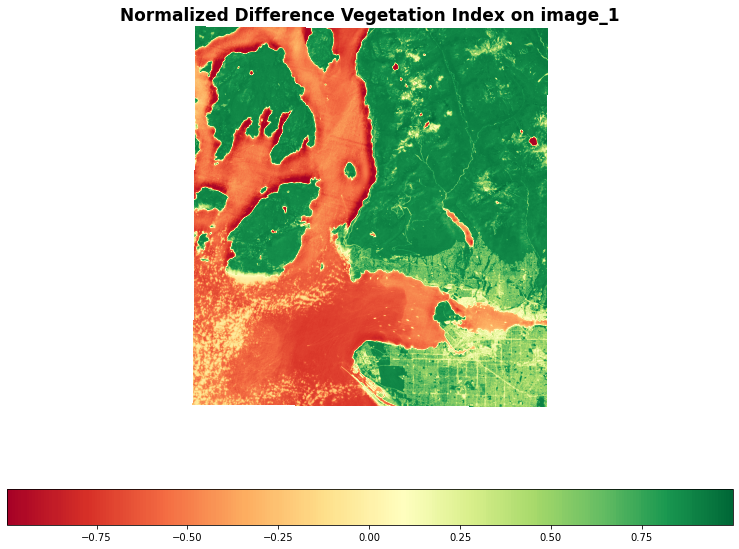

In [23]:
# Set min/max values from NDVI range for image
min_1=numpy.nanmin(ndvi_1)
max_1=numpy.nanmax(ndvi_1)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlGn 
norm_1 = MidpointNormalize(vmin=min_1, vmax=max_1, midpoint=mid)
fig_1 = plt.figure(figsize=(20,10))

ax = fig_1.add_subplot(111)

# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
cbar_plot = ax.imshow(ndvi_1, cmap=colormap, norm=norm_1)

# Turn off the display of axis labels 
ax.axis('off')

# Set a title 
ax.set_title('Normalized Difference Vegetation Index on image_1', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig_1.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save the plots to image files
fig_1.savefig("img/ndvi-image_1.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()

#### Generating a histogram of NDVI values

A Histogram or any other chart  can be useful for quick analysis by giving a visual insight into the distribution of "healthy" vs "unhealthy" vegetation values in your study area.

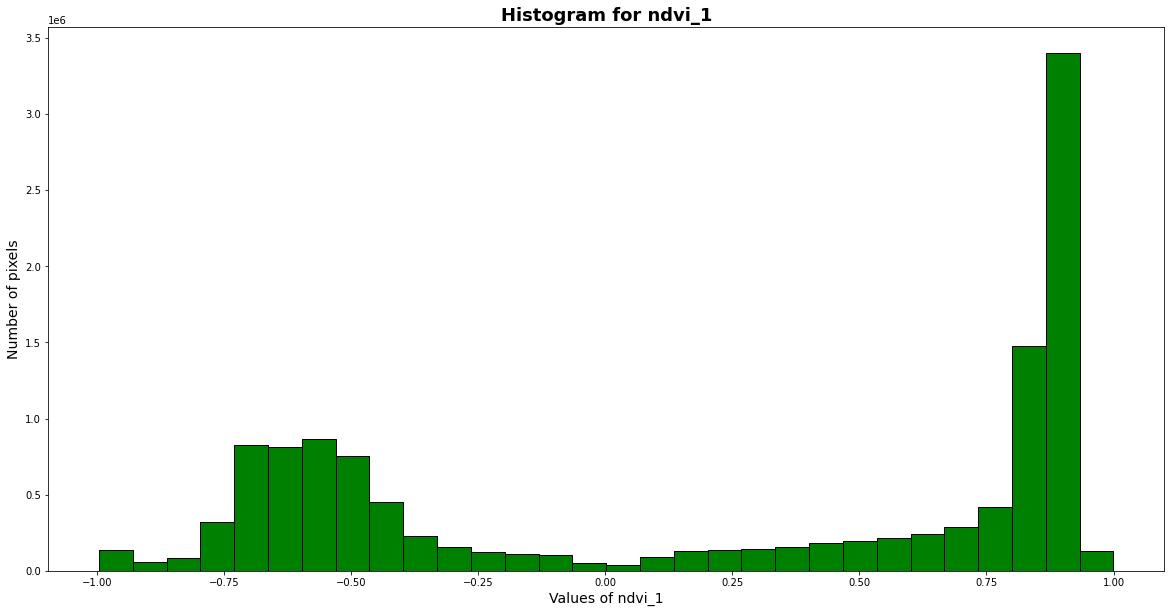

In [25]:
# Define a new figure
histo_1 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = histo_1.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("Histogram for ndvi_1", fontsize=18, fontweight='bold')
plt.xlabel("Values of ndvi_1", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)


# For the x-axis, we want to count every pixel that is not an empty value
x = ndvi_1[~numpy.isnan(ndvi_1)]
color = 'g'
# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

# Save the generated figure to an external image file
histo_1.savefig("img/histogram_for_ndvi_1.png", dpi=200, bbox_inches='tight', pad_inches=0.5)


plt.show()

### Normalized difference water index (NDWI)
For the fun of it let us have a look at the Normalized difference water index, too. It is for waterbody detection or change in water level (e.g. flooding). The green and NIR spectral bands can be used for this. Note that the NIR and Shortwave infrared (SWIR) are also used depending on the application and the available satellite data.

$$
  \rm{NDWI}= \frac{({\rm{Green}}-{\rm{NIR}})}{({\rm{Green}}+{\rm{NIR}})}
$$

#### Interpretation of the NDWI
For the variant of the NDWI using green and NIR wavelength the following interpretation is used: 

    NDWI < 0.3  ---->  Non-water
    NDWI >= 0.3 ---->  Water.

In [34]:
band_green_1 = sat_data_1.read(2)
band_nir_1 = sat_data_1.read(4)

# Do not display error when divided by zero 
numpy.seterr(divide='ignore', invalid='ignore')

# NDVI 
ndwi_1 = (band_green_1.astype(float) - band_nir_1.astype(float)) / (band_green_1 + band_nir_1)

Lets plot the NDWI for our satellite image

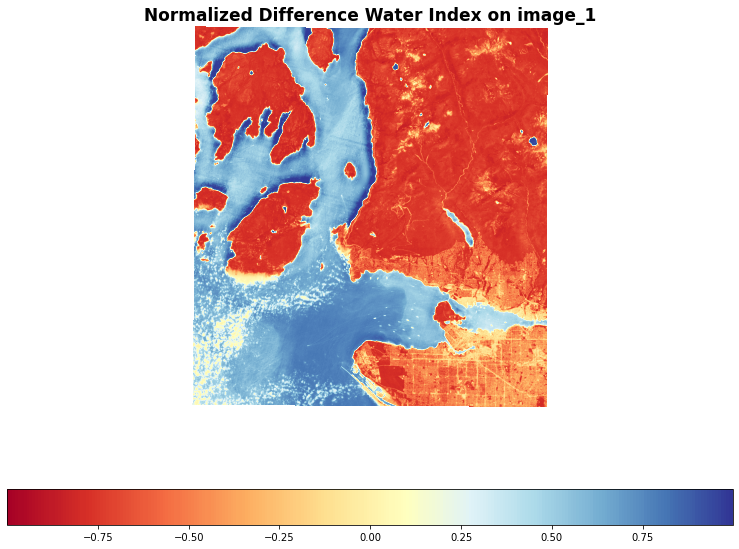

In [29]:
# Set min/max values from NDVI range for image
min_1=numpy.nanmin(ndwi_1)
max_1=numpy.nanmax(ndwi_1)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlBu 
norm_1 = MidpointNormalize(vmin=min_1, vmax=max_1, midpoint=mid)
fig_1 = plt.figure(figsize=(20,10))

ax = fig_1.add_subplot(111)

# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
cbar_plot = ax.imshow(ndwi_1, cmap=colormap, norm=norm_1)

# Turn off the display of axis labels 
ax.axis('off')

# Set a title 
ax.set_title('Normalized Difference Water Index on image_1', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig_1.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save the plots to image files
fig_1.savefig("img/ndwi-image_1.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()